In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.3.0 

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 3.8MB 34.4MB/s 
     |████████████████████████████████| 512kB 45.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=759a5403c70b56b4b40557ce32bff365f93a9e02f1e0192b40f74b3decca3992
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [7]:
import tensorflow as tf
#tf.random.set_seed(123)
print(tf.__version__)

import keras, os
from keras.models import Sequential  
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt

print(keras.__version__)

import numpy as np
np.random.seed(123)
np.set_printoptions(suppress=True)
import pickle as pk
import cv2 as cv
import pandas as pd


2.4.1
2.4.3


In [ ]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
X = np.asarray(pk.load(open("/content/drive/MyDrive/MLiSP2/Data_Channels/Data_RGB.pkl", "rb")))
holdout = np.asarray(pk.load(open("/content/drive/MyDrive/MLiSP2/Holdout_Channels/Holdout_RGB.pkl", "rb")))
y = np.genfromtxt('/content/drive/MyDrive/MLiSP2/training_norm.csv',delimiter=",")[1:,1:]
#y2 = np.genfromtxt('/content/drive/MyDrive/MLiSP2/training_norm.csv',delimiter=",")[1:,2]

X = X / 255
#print(f"{X.shape} | {holdout.shape} | {y.shape}")

In [6]:
def classImbalanceCheck(Data):
    

    label = ["0","1"]
    fig, ax = plt.subplots(1, figsize=(12,18))
    
    Data = np.bincount(Data)
    
    
    ax.set_title("Training_Data - Speed", fontsize=20)
    ax.pie(Data,labels=label, autopct='%1.1f%%', startangle=90, explode = (0.05, 0))    
    ax.axis('equal')
    plt.show()
#    fig.savefig("classImbalanceCheck.png")
    plt.clf()

In [8]:
y = pd.DataFrame(y, columns=["ANGLE", "SPEED"])
y["SPEED"] = y["SPEED"].astype(int)
print(y)

        ANGLE  SPEED
0      0.4375      0
1      0.8125      1
2      0.4375      1
3      0.6250      1
4      0.5000      0
...       ...    ...
13788  0.6250      1
13789  0.4375      1
13790  0.5625      0
13791  0.6250      0
13792  0.6875      1

[13793 rows x 2 columns]


In [9]:
print(y["ANGLE"].mean())

0.6050623504676285


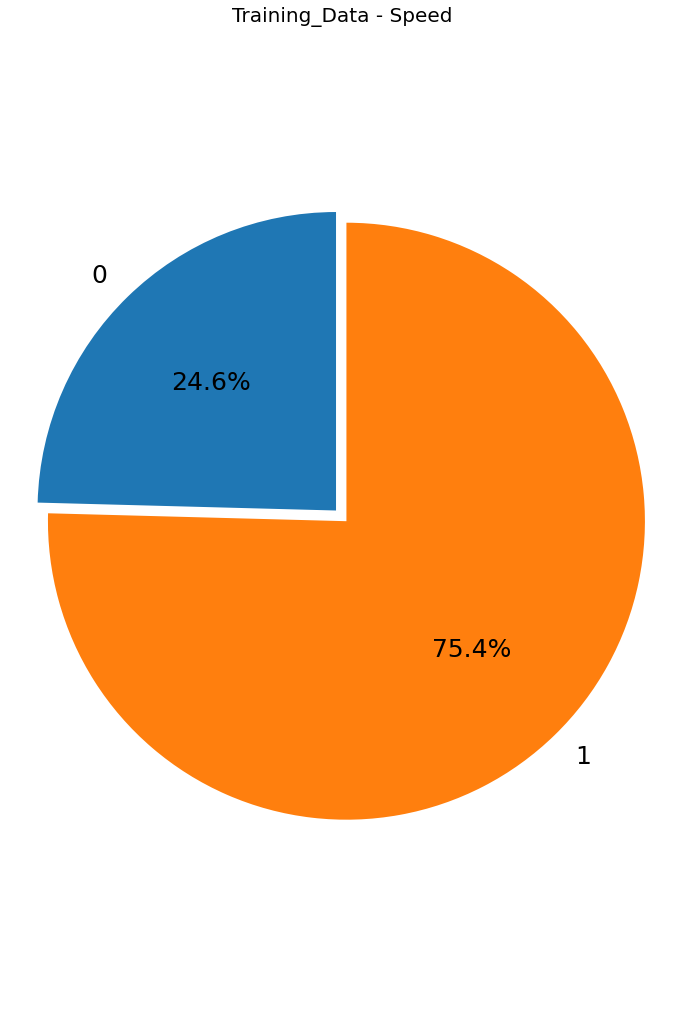

<Figure size 432x288 with 0 Axes>

In [ ]:
classImbalanceCheck(y["SPEED"])

Text(0.5, 1.0, 'Autonomous Driving Data - Angles')

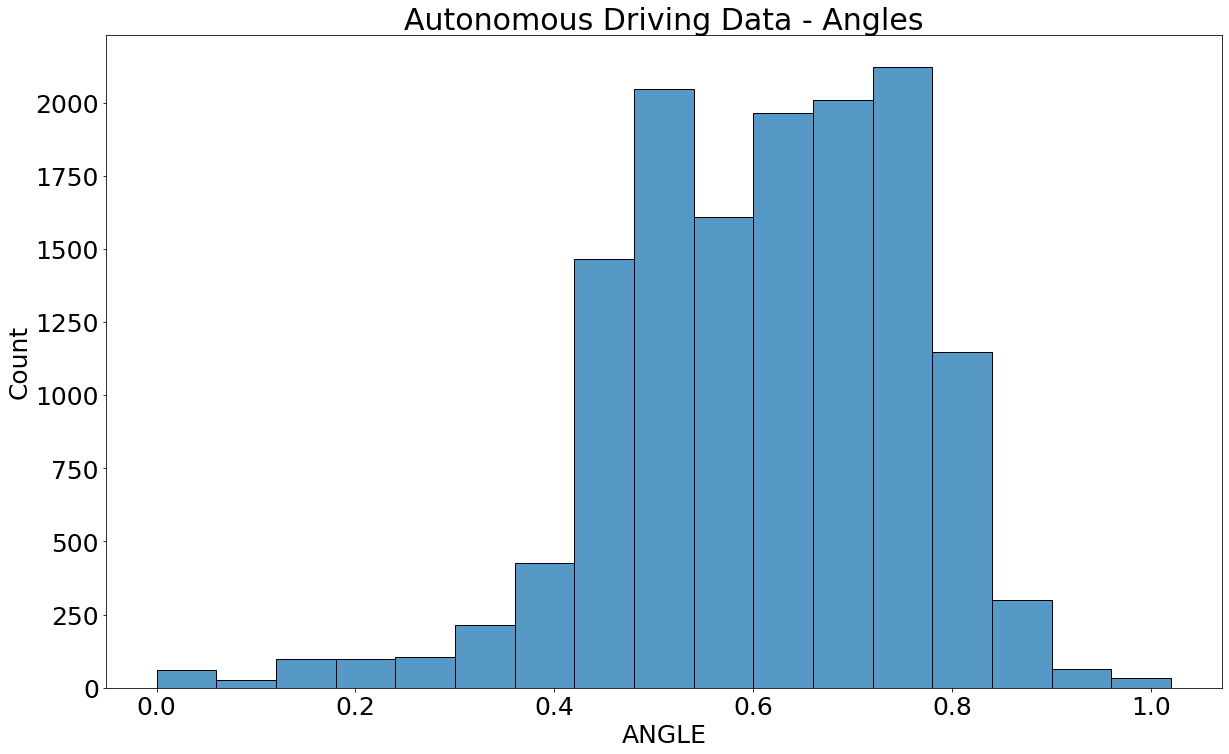

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,12))
sns.histplot(y["ANGLE"],  binwidth=0.06).set_title("Autonomous Driving Data - Angles")

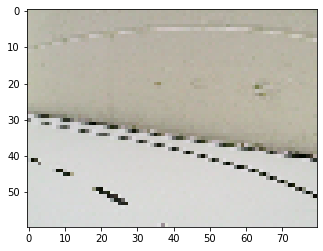

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(holdout[3])

In [ ]:
def shuffle_sets(X, y):
    """
        Shuffle function
        
    """
    concat_data = list(zip(X, y))
    np.random.shuffle(concat_data)
    X, y = list(zip(*concat_data))
    
    return np.asarray(X), np.asarray(y)

def train_test_split_manual(X, y, split=0.8):
    """
        Data splitting function 
        
    """
    X, y = shuffle_sets(X, y)
    X_train, y_train = X[:round(X.shape[0]*split)], y[:round(X.shape[0]*split)]
    X_test, y_test = X[X_train.shape[0]:], y[y_train.shape[0]:]
    
    return X_train, y_train, X_test, y_test

# manual method
#X_train, y_train, X_test, y_test = train_test_split_manual(X, y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)


#print(f"{X_train.shape} | {y_train.shape} | {X_test.shape} | {y_test.shape}")

In [ ]:
def plotLearningCurve(hist):
    
    fig, ax = plt.subplots(1,1, figsize=(18,12))
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    plt.title('Model Loss',fontsize=14)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.legend(['train','Validation'],loc='best')
    plt.tight_layout()
    plt.show()
    fig.savefig("/content/drive/MyDrive/MLiSP2/Training_V_Valdiation_Loss.png")
    
    fig, ax = plt.subplots(1,1, figsize=(18,12))
    ax.plot(hist.history['acc'])
    ax.plot(hist.history['val_acc'])
    plt.title('Model Accuracy',fontsize=14)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.legend(['train','Validation'],loc='best')
    plt.tight_layout()
    plt.show()
    fig.savefig("/content/drive/MyDrive/MLiSP2/Training_V_Valdiation_Accuracy.png")

In [ ]:
model = Sequential(name='Fail_Model')

model.add(Conv2D(16, (3, 3), strides=(2, 2), input_shape=(60, 80, 3), activation='relu')) 
model.add(Conv2D(32, (3, 3), strides=(2, 2), activation='relu')) 
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation='relu')) 


model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))

model.add(Dense(1)) 

model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=["mse"])

print(model.summary())


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Fail_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 39, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 19, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 9, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               345700    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________

In [ ]:
history = model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=10,validation_split=0.1)
loss, _ = model.evaluate(X_test, y_test)
print(f"Testing Loss: {loss}")


Train on 9930 samples, validate on 1104 samples
Epoch 1/10
9930/9930 [==============================] - 3s 307us/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 2/10
9930/9930 [==============================] - 2s 197us/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3/10
9930/9930 [==============================] - 2s 196us/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4/10
9930/9930 [==============================] - 2s 197us/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 5/10
9930/9930 [==============================] - 2s 193us/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 6/10
9930/9930 [==============================] - 2s 192us/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7/10
9930/9930 [==============================] - 2s 189us/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0076 - val_mse: 0.0076

In [ ]:
#!pip install tensorflow==2.1.0
plotLearningCurve(history)

['loss', 'mse']


RuntimeError: ignored

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/MLiSP2/Angle_Model.h5")
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 39, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 19, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 9, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               345700    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
______________________________________

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/MLiSP2/angle_model_plot.png', show_shapes=True, show_layer_names=True)
print(len(model.layers))

8


In [ ]:
if np.max(holdout) != 1.0:
  holdout = holdout / 255
print(holdout)

In [ ]:
#holdout *= 255

In [ ]:
pred = abs(model.predict(holdout))
print(pred)

[[0.5635063 ]
 [0.79927427]
 [0.30323684]
 ...
 [0.4707282 ]
 [0.5642923 ]
 [0.22980636]]


In [ ]:
import pandas as pd

columns = ["image_id", "angle", "speed"]

speed = np.genfromtxt("/content/drive/MyDrive/MLiSP2/speed_obj_dect.csv").reshape(-1, 1)
#speed = np.asarray([(i - 0) / 35 for i in pred[:, 1]]).reshape(-1, 1)

angle = np.asarray([round(i, 3) for i in pred[:,0].tolist()]).reshape(-1, 1)
#angle = np.asarray([abs((i - 50) / 80) for i in pred[:,0]]).reshape(-1, 1)

image_id = np.asarray(range(1, holdout.shape[0] + 1)).reshape(-1, 1).astype(int)

concat_columns = np.concatenate((image_id, angle, speed), axis=1)
results = pd.DataFrame(concat_columns, columns=columns)

results["image_id"] = results["image_id"].astype(int)
results["speed"] = results["speed"].astype(int)

print(results)
results.to_csv("/content/drive/MyDrive/MLiSP2/holdout_submission.csv", header=True, index=False)


      image_id  angle  speed
0            1  0.564      0
1            2  0.799      1
2            3  0.303      1
3            4  0.256      1
4            5  0.076      1
...        ...    ...    ...
1015      1016  0.497      1
1016      1017  0.667      0
1017      1018  0.471      1
1018      1019  0.564      1
1019      1020  0.230      1

[1020 rows x 3 columns]


In [ ]:
results.groupby('speed').nunique()

,image_id,angle
speed,,
0,495,294
1,525,382
